In [5]:
from torch.utils.data import DataLoader, WeightedRandomSampler
from resnet import ResNet
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, RocCurveDisplay
import numpy as np
from custom_dataset import FinalDataset, BeatsDataset
import torch
from torch import nn
import torch.optim as optim
import matplotlib.pyplot as plt
from FocalLoss import FocalLoss
import copy

In [3]:
file_path= "./data/Dataset.hdf5"
dataset = FinalDataset(file_path ,downsample=True,majority_ratio=0.50)

In [ ]:
# labels = dataset.get_labels()

In [ ]:
# unique_classes, class_counts = np.unique(labels, return_counts=True)
# class_counts_dict = dict(zip(unique_classes, class_counts))
# class_counts_dict

In [ ]:
# complete_dataset = FinalDataset(file_path)

In [ ]:
# len(complete_dataset)

In [4]:
print(len(dataset))

16380


In [4]:
def train_loop(dataloader, model, loss_fn, optimizer, device, l1_lambda=1e-5):
    size = len(dataloader.dataset.indices)
    model.train()
    total_loss = 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        pred = model(X)

        bce_loss = loss_fn(pred, y).mean()
        
        l1_norm = sum(p.abs().sum() for p in model.parameters())
        loss = bce_loss + l1_lambda * l1_norm
        
        total_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        if batch % 100 == 0:
            print(f"loss: {loss.item():>7f} [{batch * len(X):>5d}/{size:>5d}]")
    return total_loss / len(dataloader)


def test_loop(dataloader, model, loss_fn, device,val = False):
    size = len(dataloader.dataset.indices)
    total_loss = 0
    model.eval()
    all_preds, all_targets = [], []
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss = loss_fn(pred, y).mean()
            total_loss += loss.item()
            all_preds.append(pred.cpu())
            all_targets.append(y.cpu())
    
    all_preds = torch.cat(all_preds)
    all_targets = torch.cat(all_targets)

    probabilities = torch.sigmoid(all_preds)

    targets = all_targets.int().numpy()

    # for threshold in np.arange(0.1, 1.0, 0.1):
    #     print(f"\n==== Threshold: {threshold:.1f} ====")
    #     predicted = (probabilities > threshold).int().numpy()

    #     cm = confusion_matrix(targets, predicted)
    #     print("Confusion Matrix:")
    #     print(cm)
        
    #     report = classification_report(targets, predicted, digits=4, zero_division=0)
    #     print("Classification Report:")
    #     print(report)
    if val:
        RocCurveDisplay.from_predictions(all_targets, probabilities, name="ROC Curve")
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
        plt.title('ROC Curve')
        plt.savefig('roc_curve_RETE_FINALE_5_LR_PLATEAU.png')
        plt.show()
    return total_loss / len(dataloader)



Parametri

In [6]:
# Focal loss parameters
gamma = 2.0
alpha = 0.95

# ResNet parameters
in_channels = 12
out_channels = 64

# Optimizer parameters
learning_rate = 5e-4
momentum = 0.9
weight_decay = 1e-4

random_state = 42

# Training parameters
epochs = 200
batch_size = 256

patience, count = 10,0

In [7]:
train_val_idx, test_idx = train_test_split(
    np.arange(len(dataset)),
    test_size=0.15,
    random_state=random_state,
    stratify=dataset.get_labels()
)
train_val_idx.sort()
train_idx, val_idx = train_test_split(
    train_val_idx,
    test_size=0.17647,  # ~15% of total
    random_state=random_state,
    stratify=dataset.labels[train_val_idx]
)

In [10]:
train_loader = DataLoader(FinalDataset("./data/Dataset.hdf5", indices = dataset.indices[train_idx]), batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(FinalDataset("./data/Dataset.hdf5", indices = dataset.indices[val_idx]),   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(FinalDataset("./data/Dataset.hdf5", indices = dataset.indices[test_idx]),  batch_size=batch_size, shuffle=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Epoch 1
-------------------------------
loss: 2.533705 [    0/11466]
New best model saved with validation loss: 3.3949
Train Loss: 6.9195 | Val Loss: 3.3949
Epoch 2
-------------------------------
loss: 5.848703 [    0/11466]
Train Loss: 4.1132 | Val Loss: 7.1017
Epoch 3
-------------------------------
loss: 2.968524 [    0/11466]
New best model saved with validation loss: 0.7342
Train Loss: 2.8073 | Val Loss: 0.7342
Epoch 4
-------------------------------
loss: 2.304279 [    0/11466]
New best model saved with validation loss: 0.6876
Train Loss: 2.0853 | Val Loss: 0.6876
Epoch 5
-------------------------------
loss: 1.831865 [    0/11466]
New best model saved with validation loss: 0.6571
Train Loss: 1.6956 | Val Loss: 0.6571
Epoch 6
-------------------------------
loss: 1.519054 [    0/11466]
New best model saved with validation loss: 0.6240
Train Loss: 1.4797 | Val Loss: 0.6240
Epoch 7
-------------------------------
loss: 1.355357 [    0/11466]
Train Loss: 1.3375 | Val Loss: 0.6381
E

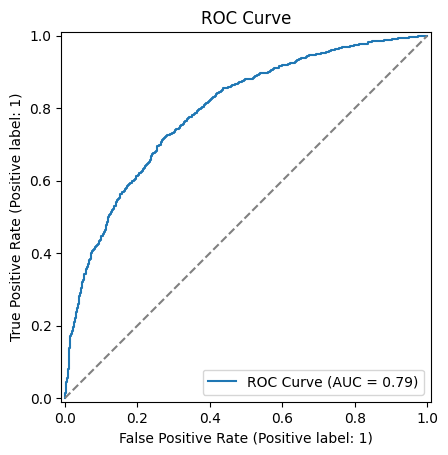

Final Test Loss: 0.5623


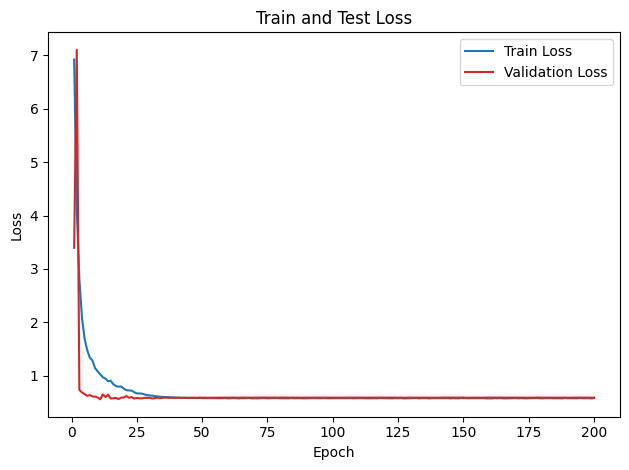

Saved model
Training Completed!


In [ ]:


# Load dataset labels
# labels = np.array(dataset.get_labels() ,dtype=np.int32)
# labels = labels.squeeze()

# Class counts and pos_weight for BCEWithLogitsLoss
# unique_classes, class_counts = np.unique(labels, return_counts=True)
# class_counts_dict = dict(zip(unique_classes, class_counts))
# print(f"Class counts: {class_counts_dict}")


# # with 95% majority ratio
# pos_weight = torch.tensor(155609/ 8190).to(device)
# loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# with 50% majority ratio
loss_fn = nn.BCEWithLogitsLoss()

# with Focal Loss and 95% majority ratio
# loss_fn = FocalLoss(gamma, alpha)

# Model and optimizer
model = ResNet(in_channels, out_channels).to(device)
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
# optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

train_loader = DataLoader(FinalDataset("./data/Dataset.hdf5", indices = dataset.indices[train_idx]), batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(FinalDataset("./data/Dataset.hdf5", indices = dataset.indices[val_idx]),   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(FinalDataset("./data/Dataset.hdf5", indices = dataset.indices[test_idx]),  batch_size=batch_size, shuffle=False)

# Single train/val loop
train_losses = []
val_losses = []
best_loss = float('inf')
best_model_state = None
count = 0

for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train_loss = train_loop(train_loader, model, loss_fn, optimizer, device, l1_lambda=1e-5)
    val_loss = test_loop(val_loader, model, loss_fn, device)
    scheduler.step(val_loss)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    if val_loss < best_loss:
        best_loss = val_loss
        count = 0
        # Save the best model state
        best_model_state = copy.deepcopy(model.state_dict())
        print(f"New best model saved with validation loss: {val_loss:.4f}")
    # else:
    #     count += 1
    #     print(f"No improvement for {count} epochs. Best val loss: {best_loss:.4f}")

    # if count >= patience:
    #     print(f"Early stopping triggered after {epoch+1} epochs")
    #     break

    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print("Loaded best model for testing")

# Test after training
test_loss = test_loop(test_loader, model, loss_fn, device, val=True)
print(f"Final Test Loss: {test_loss:.4f}")

fig, ax = plt.subplots()

ax.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss", color='tab:blue')
ax.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss", color='tab:red')

ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend()

plt.title(f"Train and Test Loss")
plt.tight_layout()
plt.savefig(f"train_test_loss_RETE_FINALE_5_LR_PLATEAU.png")
plt.show()

torch.save(model.state_dict(), f"model_RETE_FINALE_5_LR_PLATEAU.pth")
print(f"Saved model")

print("Training Completed!")


Final Test Loss: 0.5623


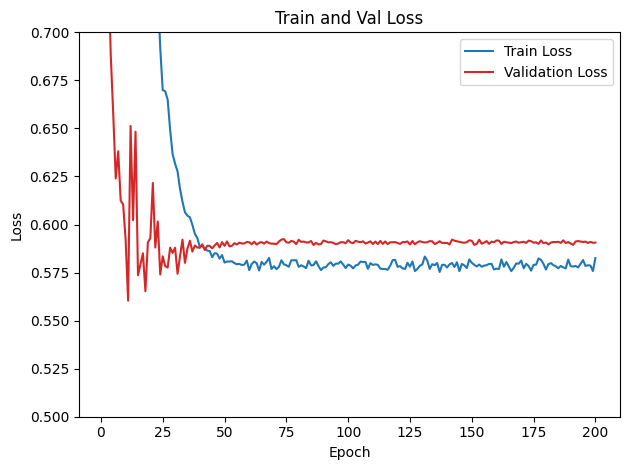

In [34]:
print(f"Final Test Loss: {test_loss:.4f}")

fig, ax = plt.subplots()

ax.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss", color='tab:blue')
ax.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss", color='tab:red')

ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend()
plt.ylim(0.5, 0.7)
plt.title(f"Train and Val Loss")
plt.tight_layout()
plt.savefig(f"train_val_loss_RETE_FINALE_5_LR_PLATEAU_ZOOMED.png")
plt.show()

<img src="train_val_loss_RETE_FINALE_5_LR_PLATEAU_ZOOMED.png">

Best threshold: 0.44089103


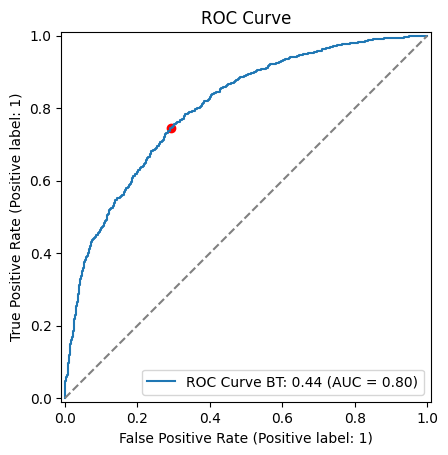

In [11]:
# Reload the old model
old_model = ResNet(in_channels, out_channels).to(device)
old_model.load_state_dict(torch.load("model_RETE_FINALE_5_LR_PLATEAU.pth"))
old_model.eval()

# Generate predictions and plot ROC curve
all_preds, all_targets = [], []

with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        pred = old_model(X)
        all_preds.append(pred.cpu())
        all_targets.append(y.cpu())

all_preds = torch.cat(all_preds)
all_targets = torch.cat(all_targets)

probabilities = torch.sigmoid(all_preds)
from sklearn.metrics import roc_curve

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(all_targets.numpy(), probabilities.numpy())

# Find the point on the ROC curve with the smallest distance to (0, 1)
distances = np.sqrt((fpr - 0)**2 + (tpr - 1)**2)
min_distance_idx = np.argmin(distances)
optimal_fpr, optimal_tpr = fpr[min_distance_idx], tpr[min_distance_idx]

best_threshold = thresholds[min_distance_idx]
print("Best threshold:", best_threshold)
# Plot the ROC curve and mark the optimal point
RocCurveDisplay.from_predictions(all_targets, probabilities, name=f"ROC Curve BT: {best_threshold:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.scatter(optimal_fpr, optimal_tpr, color='red')

plt.title('ROC Curve')
plt.legend()
plt.savefig('optimalThreshold_SGD_BCEWL_95_L.png')
plt.show()

In [ ]:
predicted = (probabilities > best_threshold).int().numpy()
cm = confusion_matrix(all_targets.int().numpy(), predicted)
print("Confusion Matrix:")
print(cm)
report = classification_report(all_targets.int().numpy(), predicted, digits=4, zero_division=0)
print("Classification Report:")
print(report)

In [16]:
from sklearn.metrics import f1_score, confusion_matrix

best_threshold_f1 = 0
best_f1 = 0
best_threshold_specificity = 0
best_specificity = 0

for t in np.arange(0.1, 1.0, 0.01):
    all_preds, all_targets = [], []

    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            pred = old_model(X)
            all_preds.append(pred.cpu())
            all_targets.append(y.cpu())

    all_preds = torch.cat(all_preds)
    all_targets = torch.cat(all_targets)

    probs = torch.sigmoid(all_preds).numpy()
    y_true = all_targets.numpy()

    preds = (probs > t).astype(int)
    cm = confusion_matrix(y_true, preds)
    tn, fp, fn, tp = cm.ravel()

    specificity = tn / (tn + fp)
    f1 = f1_score(y_true, preds)
    
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t
    if specificity > best_specificity:
        best_specificity = specificity
        best_threshold_specificity = t

print("Best threshold for F1 score:", best_threshold)
print("Best F1 score:", best_f1)
print("Best threshold for specificity:", best_threshold_specificity)
print("Best specificity:", best_specificity)



Best threshold for F1 score: 0.3799999999999999
Best F1 score: 0.7446197991391679
Best threshold for specificity: 0.8999999999999996
Best specificity: 1.0


Average Beat training

In [7]:
file_path= "./data/average_beats.hdf5"
dataset2 = BeatsDataset(file_path ,downsample=True,majority_ratio=0.50)

In [8]:
train_val_idx_2, test_idx_2 = train_test_split(
    np.arange(len(dataset2)),
    test_size=0.15,
    random_state=random_state,
    stratify=dataset2.get_labels()
)
train_val_idx_2.sort()
train_idx_2, val_idx_2 = train_test_split(
    train_val_idx_2,
    test_size=0.17647,  # ~15% of total
    random_state=random_state,
    stratify=dataset2.labels[train_val_idx_2]
)
train_loader_2 = DataLoader(BeatsDataset("./data/average_beats.hdf5", indices = dataset2.indices[train_idx_2]), batch_size=batch_size, shuffle=True)
val_loader_2   = DataLoader(BeatsDataset("./data/average_beats.hdf5", indices = dataset2.indices[val_idx_2]),   batch_size=batch_size, shuffle=False)
test_loader_2  = DataLoader(BeatsDataset("./data/average_beats.hdf5", indices = dataset2.indices[test_idx_2]),  batch_size=batch_size, shuffle=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Average  Beat

In [9]:
def train_loop(dataloader, model, loss_fn, optimizer, device, l1_lambda=1e-5):
    size = len(dataloader.dataset.indices)
    model.train()
    total_loss = 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        pred = model(X)

        bce_loss = loss_fn(pred, y).mean()
        
        l1_norm = sum(p.abs().sum() for p in model.parameters())
        loss = bce_loss + l1_lambda * l1_norm
        
        total_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        if batch % 100 == 0:
            print(f"loss: {loss.item():>7f} [{batch * len(X):>5d}/{size:>5d}]")
    return total_loss / len(dataloader)


def test_loop(dataloader, model, loss_fn, device,val = False):
    size = len(dataloader.dataset.indices)
    total_loss = 0
    model.eval()
    all_preds, all_targets = [], []
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss = loss_fn(pred, y).mean()
            total_loss += loss.item()
            all_preds.append(pred.cpu())
            all_targets.append(y.cpu())
    
    all_preds = torch.cat(all_preds)
    all_targets = torch.cat(all_targets)

    probabilities = torch.sigmoid(all_preds)

    targets = all_targets.int().numpy()

    # for threshold in np.arange(0.1, 1.0, 0.1):
    #     print(f"\n==== Threshold: {threshold:.1f} ====")
    #     predicted = (probabilities > threshold).int().numpy()

    #     cm = confusion_matrix(targets, predicted)
    #     print("Confusion Matrix:")
    #     print(cm)
        
    #     report = classification_report(targets, predicted, digits=4, zero_division=0)
    #     print("Classification Report:")
    #     print(report)
    if val:
        RocCurveDisplay.from_predictions(all_targets, probabilities, name="ROC Curve")
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
        plt.title('ROC Curve')
        plt.savefig('roc_curve_RETE_BEATS.png')
        plt.show()
    return total_loss / len(dataloader)



Epoch 1
-------------------------------
loss: 2.239985 [    0/11433]
New best model saved with validation loss: 0.6527
Train Loss: 2.0812 | Val Loss: 0.6527
Epoch 2
-------------------------------
loss: 1.928635 [    0/11433]
New best model saved with validation loss: 0.6118
Train Loss: 1.7416 | Val Loss: 0.6118
Epoch 3
-------------------------------
loss: 1.609630 [    0/11433]
New best model saved with validation loss: 0.5887
Train Loss: 1.4865 | Val Loss: 0.5887
Epoch 4
-------------------------------
loss: 1.388499 [    0/11433]
New best model saved with validation loss: 0.5887
Train Loss: 1.3058 | Val Loss: 0.5887
Epoch 5
-------------------------------
loss: 1.233454 [    0/11433]
New best model saved with validation loss: 0.5834
Train Loss: 1.1928 | Val Loss: 0.5834
Epoch 6
-------------------------------
loss: 1.122790 [    0/11433]
Train Loss: 1.1132 | Val Loss: 0.5955
Epoch 7
-------------------------------
loss: 1.054207 [    0/11433]
Train Loss: 1.0409 | Val Loss: 0.5894
E

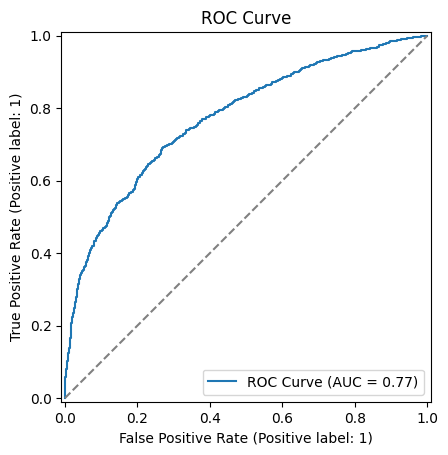

Final Test Loss: 0.5730


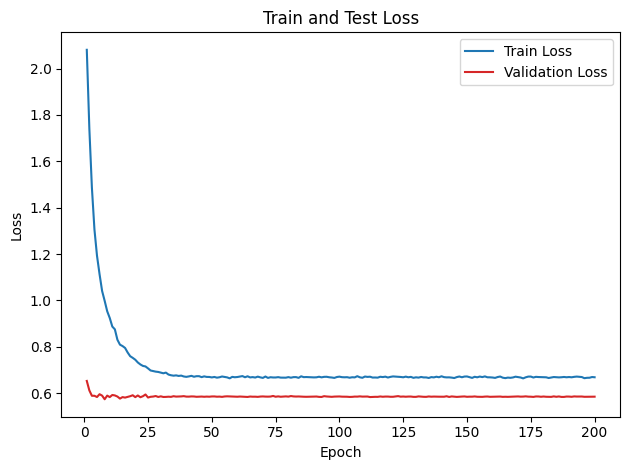

Saved model
Training Completed!


In [10]:
# Load dataset labels
# labels = np.array(dataset.get_labels() ,dtype=np.int32)
# labels = labels.squeeze()

# Class counts and pos_weight for BCEWithLogitsLoss
# unique_classes, class_counts = np.unique(labels, return_counts=True)
# class_counts_dict = dict(zip(unique_classes, class_counts))
# print(f"Class counts: {class_counts_dict}")


# # with 95% majority ratio
# pos_weight = torch.tensor(155609/ 8190).to(device)
# loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# with 50% majority ratio
loss_fn = nn.BCEWithLogitsLoss()

# with Focal Loss and 95% majority ratio
# loss_fn = FocalLoss(gamma, alpha)

# Model and optimizer
model = ResNet(in_channels, out_channels).to(device)
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
# optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# Single train/val loop
train_losses = []
val_losses = []
best_loss = float('inf')
best_model_state = None
count = 0

for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train_loss = train_loop(train_loader_2, model, loss_fn, optimizer, device, l1_lambda=1e-5)
    val_loss = test_loop(val_loader_2, model, loss_fn, device)
    scheduler.step(val_loss)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    if val_loss < best_loss:
        best_loss = val_loss
        count = 0
        # Save the best model state
        best_model_state = copy.deepcopy(model.state_dict())
        print(f"New best model saved with validation loss: {val_loss:.4f}")
    # else:
    #     count += 1
    #     print(f"No improvement for {count} epochs. Best val loss: {best_loss:.4f}")

    # if count >= patience:
    #     print(f"Early stopping triggered after {epoch+1} epochs")
    #     break

    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print("Loaded best model for testing")

# Test after training
test_loss = test_loop(test_loader_2, model, loss_fn, device, val=True)
print(f"Final Test Loss: {test_loss:.4f}")

fig, ax = plt.subplots()

ax.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss", color='tab:blue')
ax.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss", color='tab:red')

ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend()

plt.title(f"Train and Test Loss")
plt.tight_layout()
plt.savefig(f"train_test_loss_RETE_BEATS.png")
plt.show()

torch.save(model.state_dict(), f"model_RETE_BEATS.pth")
print(f"Saved model")

print("Training Completed!")


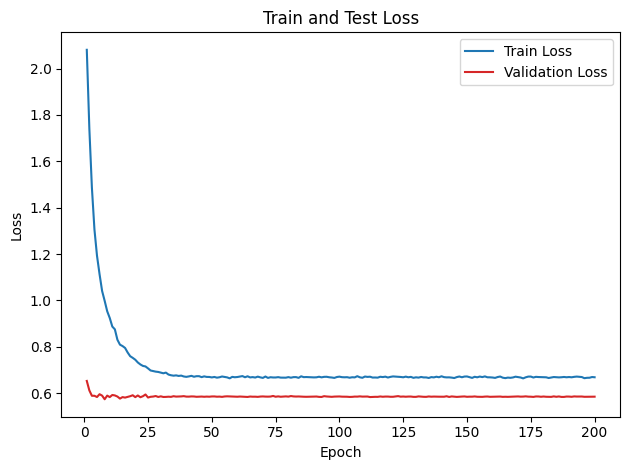

In [ ]:
fig, ax = plt.subplots()

ax.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss", color='tab:blue')
ax.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss", color='tab:red')

ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend()

plt.title(f"Train and Test Loss")
plt.tight_layout()
plt.savefig(f"train_test_loss_RETE_BEATS.png")
 
plt.show()